In [61]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [62]:
# 이미지 데이터 로드 함수 정의
def load_image(path):
    try:
        img = Image.open(path).convert('L')  # 흑백 모드로 이미지 열기
        img = img.resize((96, 96))  # 이미지 크기 조정
        return np.array(img) / 255.0  # 정규화
    except Exception as e:
        print(f"Warning: Could not load image at {path}. Error: {e}")
        return None

In [63]:
# 데이터 로드
df_train = pd.read_csv('./dataset.csv')
df1 = df_train.copy()
df1 = df1.drop(df1.columns[0], axis=1)

# 레이블을 숫자로 변환
df1 = df1.replace({'label': "기쁨"}, 0)
df1 = df1.replace({'label': "상처"}, 1)
df1 = df1.replace({'label': "분노"}, 2)
df1 = df1.replace({'label': "당황"}, 3)

C:\Users\jdm03\AppData\Local\Temp\ipykernel_22608\2524110126.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1 = df1.replace({'label': "당황"}, 3)


In [64]:
# 데이터 준비
xs = np.array(df1['path'])
ys = np.array(df1['label'])

# 데이터셋 분할
train_x, valid_x, train_y, valid_y = train_test_split(xs, ys, test_size=0.2)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)

In [65]:
# 이미지 데이터 로드 및 전처리
def preprocess_images(file_paths):
    processed_images = [load_image(item) for item in file_paths]
    processed_images = np.array([img for img in processed_images if img is not None]).reshape(-1, 96, 96, 1)
    return processed_images

In [66]:
train_x = preprocess_images(train_x)
valid_x = preprocess_images(valid_x)
test_x = preprocess_images(test_x)

# 원-핫 인코딩
train_y = tf.keras.utils.to_categorical(train_y, 4)
valid_y = tf.keras.utils.to_categorical(valid_y, 4)
test_y = tf.keras.utils.to_categorical(test_y, 4)

In [67]:
# 데이터 증강 생성기
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# 두 입력 스트림을 각각 증강하여 병합하는 함수 정의
def generate_data(generator, x1, x2, y, batch_size):
    genX1 = generator.flow(x1, y, batch_size=batch_size, seed=1)
    genX2 = generator.flow(x2, y, batch_size=batch_size, seed=1)
    while True:
        X1i = next(iter(genX1))  # iter() 사용하여 반복
        X2i = next(iter(genX2))  # iter() 사용하여 반복
        yield [X1i[0], X2i[0]], X1i[1]  # 두 개의 증강된 입력 스트림을 결합


In [68]:
# 생성된 데이터를 tf.data.Dataset으로 변환하는 함수
def create_dataset(generator, x1, x2, y, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: generate_data(generator, x1, x2, y, batch_size),
        output_signature=(
            (tf.TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32),
             tf.TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32)),
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
        )
    )
    return dataset

# Dataset 생성
train_dataset = create_dataset(datagen, train_x, train_x, train_y, batch_size=16)


In [69]:
# 외형 DCNN 정의
def build_appearance_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    outputs = Dense(128, activation='relu')(x)
    model = Model(inputs, outputs, name="appearance_model")
    return model

In [70]:
# 동적 DCNN 정의
def build_dynamics_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    outputs = Dense(128, activation='relu')(x)
    model = Model(inputs, outputs, name="dynamics_model")
    return model

In [71]:
# Joint Tuning Layer 추가한 최종 모델 정의
def build_joint_model(appearance_model, dynamics_model):
    combined_input = concatenate([appearance_model.output, dynamics_model.output])
    x = Dense(256, activation='relu')(combined_input)
    x = Dense(128, activation='relu')(x)
    final_output = Dense(4, activation='softmax')(x)  # 감정 분류를 위한 소프트맥스 출력
    model = Model(inputs=[appearance_model.input, dynamics_model.input], outputs=final_output)
    return model

In [72]:
# 입력 데이터의 형태 정의
input_shape = (96, 96, 1)
appearance_model = build_appearance_model(input_shape)
dynamics_model = build_dynamics_model(input_shape)

In [73]:
# Joint Model 생성 및 컴파일
joint_model = build_joint_model(appearance_model, dynamics_model)
joint_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
# 모델 학습
callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='model_DCNN.keras', monitor='val_loss', save_best_only=True)

history = joint_model.fit(
    train_dataset,
    steps_per_epoch=len(train_x) // 16,
    validation_data=([valid_x, valid_x], valid_y),
    epochs=50,
    callbacks=[callbacks]
)

Epoch 1/50


c:\Users\jdm03\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_106', 'keras_tensor_115']. Received: the structure of inputs=('*', '*')
  warnings.warn(


InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was ((tf.float32, tf.float32), tf.float32), but the yielded element was ([array([[[[0.8927251 ],
         [0.9435166 ],
         [0.912446  ],
         ...,
         [0.3372549 ],
         [0.3372549 ],
         [0.3372549 ]],

        [[0.8835854 ],
         [0.94743365],
         [0.9146221 ],
         ...,
         [0.33537763],
         [0.33413434],
         [0.33289108]],

        [[0.8744457 ],
         [0.9513507 ],
         [0.9167983 ],
         ...,
         [0.3254902 ],
         [0.3254902 ],
         [0.3254902 ]],

        ...,

        [[0.46799865],
         [0.46551207],
         [0.4630255 ],
         ...,
         [0.11748827],
         [0.11898629],
         [0.13073009]],

        [[0.4627451 ],
         [0.4627451 ],
         [0.4627451 ],
         ...,
         [0.1214053 ],
         [0.11768061],
         [0.12942442]],

        [[0.4627451 ],
         [0.4627451 ],
         [0.4627451 ],
         ...,
         [0.12532233],
         [0.11637493],
         [0.12811875]]],


       [[[0.56873256],
         [0.55891025],
         [0.5511354 ],
         ...,
         [0.5137255 ],
         [0.5137255 ],
         [0.5137255 ]],

        [[0.5694406 ],
         [0.55938226],
         [0.55184346],
         ...,
         [0.5137255 ],
         [0.5137255 ],
         [0.5137255 ]],

        [[0.57014865],
         [0.5598543 ],
         [0.5525515 ],
         ...,
         [0.5137255 ],
         [0.5137255 ],
         [0.5137255 ]],

        ...,

        [[0.47640443],
         [0.48411894],
         [0.3447261 ],
         ...,
         [0.25702158],
         [0.2509804 ],
         [0.2509804 ]],

        [[0.47940433],
         [0.47361585],
         [0.33660683],
         ...,
         [0.2586737 ],
         [0.2509804 ],
         [0.2509804 ]],

        [[0.47559324],
         [0.47999752],
         [0.34367135],
         ...,
         [0.26032582],
         [0.2509804 ],
         [0.2509804 ]]],


       [[[0.10473623],
         [0.10521334],
         [0.10569046],
         ...,
         [0.23566078],
         [0.24239625],
         [0.27567616]],

        [[0.10196079],
         [0.10196079],
         [0.10196079],
         ...,
         [0.2361643 ],
         [0.24451646],
         [0.28076044]],

        [[0.10196079],
         [0.10196079],
         [0.10196079],
         ...,
         [0.23718116],
         [0.24960071],
         [0.2820038 ]],

        ...,

        [[0.13624242],
         [0.12532891],
         [0.11083133],
         ...,
         [0.6235322 ],
         [0.6365693 ],
         [0.6308198 ]],

        [[0.13471715],
         [0.12329521],
         [0.11156494],
         ...,
         [0.6341594 ],
         [0.63967437],
         [0.62695587]],

        [[0.13319187],
         [0.12126151],
         [0.11512392],
         ...,
         [0.6452592 ],
         [0.64166325],
         [0.62313193]]],


       ...,


       [[[0.37939882],
         [0.2855209 ],
         [0.2731951 ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        [[0.38083267],
         [0.2760576 ],
         [0.2749157 ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        [[0.38226652],
         [0.26659426],
         [0.2766363 ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        ...,

        [[0.28843153],
         [0.31674162],
         [0.34178942],
         ...,
         [0.37393776],
         [0.38190112],
         [0.3898645 ]],

        [[0.28871828],
         [0.32018283],
         [0.34236297],
         ...,
         [0.41846374],
         [0.4126239 ],
         [0.40678412]],

        [[0.28900504],
         [0.32362404],
         [0.34293652],
         ...,
         [0.35347593],
         [0.3590503 ],
         [0.36462465]]],


       [[[0.5583866 ],
         [0.51208377],
         [0.46262816],
         ...,
         [0.44557828],
         [0.43026888],
         [0.41782886]],

        [[0.5626212 ],
         [0.5163184 ],
         [0.46751422],
         ...,
         [0.500788  ],
         [0.48112103],
         [0.46355617]],

        [[0.5668558 ],
         [0.520553  ],
         [0.47240028],
         ...,
         [0.5545815 ],
         [0.5328605 ],
         [0.5115784 ]],

        ...,

        [[0.35251278],
         [0.35221642],
         [0.35192004],
         ...,
         [0.07714666],
         [0.07358491],
         [0.07058824]],

        [[0.34901962],
         [0.34901962],
         [0.34901962],
         ...,
         [0.0774724 ],
         [0.07391065],
         [0.07058824]],

        [[0.34819022],
         [0.34759748],
         [0.34700474],
         ...,
         [0.07779814],
         [0.07423639],
         [0.07067464]]],


       [[[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [0.9999975 ]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [0.99964404]],

        ...,

        [[0.59607846],
         [0.59607846],
         [0.59607846],
         ...,
         [0.58374274],
         [0.57204306],
         [0.60454607]],

        [[0.59607846],
         [0.59607846],
         [0.59607846],
         ...,
         [0.5757507 ],
         [0.56030804],
         [0.62671715]],

        [[0.59607846],
         [0.59607846],
         [0.59607846],
         ...,
         [0.56998223],
         [0.54925346],
         [0.65049326]]]], dtype=float32), array([[[[0.8927251 ],
         [0.9435166 ],
         [0.912446  ],
         ...,
         [0.3372549 ],
         [0.3372549 ],
         [0.3372549 ]],

        [[0.8835854 ],
         [0.94743365],
         [0.9146221 ],
         ...,
         [0.33537763],
         [0.33413434],
         [0.33289108]],

        [[0.8744457 ],
         [0.9513507 ],
         [0.9167983 ],
         ...,
         [0.3254902 ],
         [0.3254902 ],
         [0.3254902 ]],

        ...,

        [[0.46799865],
         [0.46551207],
         [0.4630255 ],
         ...,
         [0.11748827],
         [0.11898629],
         [0.13073009]],

        [[0.4627451 ],
         [0.4627451 ],
         [0.4627451 ],
         ...,
         [0.1214053 ],
         [0.11768061],
         [0.12942442]],

        [[0.4627451 ],
         [0.4627451 ],
         [0.4627451 ],
         ...,
         [0.12532233],
         [0.11637493],
         [0.12811875]]],


       [[[0.56873256],
         [0.55891025],
         [0.5511354 ],
         ...,
         [0.5137255 ],
         [0.5137255 ],
         [0.5137255 ]],

        [[0.5694406 ],
         [0.55938226],
         [0.55184346],
         ...,
         [0.5137255 ],
         [0.5137255 ],
         [0.5137255 ]],

        [[0.57014865],
         [0.5598543 ],
         [0.5525515 ],
         ...,
         [0.5137255 ],
         [0.5137255 ],
         [0.5137255 ]],

        ...,

        [[0.47640443],
         [0.48411894],
         [0.3447261 ],
         ...,
         [0.25702158],
         [0.2509804 ],
         [0.2509804 ]],

        [[0.47940433],
         [0.47361585],
         [0.33660683],
         ...,
         [0.2586737 ],
         [0.2509804 ],
         [0.2509804 ]],

        [[0.47559324],
         [0.47999752],
         [0.34367135],
         ...,
         [0.26032582],
         [0.2509804 ],
         [0.2509804 ]]],


       [[[0.10473623],
         [0.10521334],
         [0.10569046],
         ...,
         [0.23566078],
         [0.24239625],
         [0.27567616]],

        [[0.10196079],
         [0.10196079],
         [0.10196079],
         ...,
         [0.2361643 ],
         [0.24451646],
         [0.28076044]],

        [[0.10196079],
         [0.10196079],
         [0.10196079],
         ...,
         [0.23718116],
         [0.24960071],
         [0.2820038 ]],

        ...,

        [[0.13624242],
         [0.12532891],
         [0.11083133],
         ...,
         [0.6235322 ],
         [0.6365693 ],
         [0.6308198 ]],

        [[0.13471715],
         [0.12329521],
         [0.11156494],
         ...,
         [0.6341594 ],
         [0.63967437],
         [0.62695587]],

        [[0.13319187],
         [0.12126151],
         [0.11512392],
         ...,
         [0.6452592 ],
         [0.64166325],
         [0.62313193]]],


       ...,


       [[[0.37939882],
         [0.2855209 ],
         [0.2731951 ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        [[0.38083267],
         [0.2760576 ],
         [0.2749157 ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        [[0.38226652],
         [0.26659426],
         [0.2766363 ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        ...,

        [[0.28843153],
         [0.31674162],
         [0.34178942],
         ...,
         [0.37393776],
         [0.38190112],
         [0.3898645 ]],

        [[0.28871828],
         [0.32018283],
         [0.34236297],
         ...,
         [0.41846374],
         [0.4126239 ],
         [0.40678412]],

        [[0.28900504],
         [0.32362404],
         [0.34293652],
         ...,
         [0.35347593],
         [0.3590503 ],
         [0.36462465]]],


       [[[0.5583866 ],
         [0.51208377],
         [0.46262816],
         ...,
         [0.44557828],
         [0.43026888],
         [0.41782886]],

        [[0.5626212 ],
         [0.5163184 ],
         [0.46751422],
         ...,
         [0.500788  ],
         [0.48112103],
         [0.46355617]],

        [[0.5668558 ],
         [0.520553  ],
         [0.47240028],
         ...,
         [0.5545815 ],
         [0.5328605 ],
         [0.5115784 ]],

        ...,

        [[0.35251278],
         [0.35221642],
         [0.35192004],
         ...,
         [0.07714666],
         [0.07358491],
         [0.07058824]],

        [[0.34901962],
         [0.34901962],
         [0.34901962],
         ...,
         [0.0774724 ],
         [0.07391065],
         [0.07058824]],

        [[0.34819022],
         [0.34759748],
         [0.34700474],
         ...,
         [0.07779814],
         [0.07423639],
         [0.07067464]]],


       [[[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [0.9999975 ]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [0.99964404]],

        ...,

        [[0.59607846],
         [0.59607846],
         [0.59607846],
         ...,
         [0.58374274],
         [0.57204306],
         [0.60454607]],

        [[0.59607846],
         [0.59607846],
         [0.59607846],
         ...,
         [0.5757507 ],
         [0.56030804],
         [0.62671715]],

        [[0.59607846],
         [0.59607846],
         [0.59607846],
         ...,
         [0.56998223],
         [0.54925346],
         [0.65049326]]]], dtype=float32)], array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])).
Traceback (most recent call last):

  File "c:\Users\jdm03\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 204, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\jdm03\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\data\util\nest.py", line 237, in flatten_up_to
    return nest_util.flatten_up_to(
           ^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\jdm03\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\util\nest_util.py", line 1541, in flatten_up_to
    return _tf_data_flatten_up_to(shallow_tree, input_tree)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\jdm03\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\util\nest_util.py", line 1570, in _tf_data_flatten_up_to
    _tf_data_assert_shallow_structure(shallow_tree, input_tree)

  File "c:\Users\jdm03\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\util\nest_util.py", line 1444, in _tf_data_assert_shallow_structure
    _tf_data_assert_shallow_structure(

  File "c:\Users\jdm03\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\util\nest_util.py", line 1414, in _tf_data_assert_shallow_structure
    raise TypeError(

TypeError: If shallow structure is a sequence, input must also be a sequence. Input has type: 'list'.


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "c:\Users\jdm03\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\jdm03\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\jdm03\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 206, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was ((tf.float32, tf.float32), tf.float32), but the yielded element was ([array([[[[0.8927251 ],
         [0.9435166 ],
         [0.912446  ],
         ...,
         [0.3372549 ],
         [0.3372549 ],
         [0.3372549 ]],

        [[0.8835854 ],
         [0.94743365],
         [0.9146221 ],
         ...,
         [0.33537763],
         [0.33413434],
         [0.33289108]],

        [[0.8744457 ],
         [0.9513507 ],
         [0.9167983 ],
         ...,
         [0.3254902 ],
         [0.3254902 ],
         [0.3254902 ]],

        ...,

        [[0.46799865],
         [0.46551207],
         [0.4630255 ],
         ...,
         [0.11748827],
         [0.11898629],
         [0.13073009]],

        [[0.4627451 ],
         [0.4627451 ],
         [0.4627451 ],
         ...,
         [0.1214053 ],
         [0.11768061],
         [0.12942442]],

        [[0.4627451 ],
         [0.4627451 ],
         [0.4627451 ],
         ...,
         [0.12532233],
         [0.11637493],
         [0.12811875]]],


       [[[0.56873256],
         [0.55891025],
         [0.5511354 ],
         ...,
         [0.5137255 ],
         [0.5137255 ],
         [0.5137255 ]],

        [[0.5694406 ],
         [0.55938226],
         [0.55184346],
         ...,
         [0.5137255 ],
         [0.5137255 ],
         [0.5137255 ]],

        [[0.57014865],
         [0.5598543 ],
         [0.5525515 ],
         ...,
         [0.5137255 ],
         [0.5137255 ],
         [0.5137255 ]],

        ...,

        [[0.47640443],
         [0.48411894],
         [0.3447261 ],
         ...,
         [0.25702158],
         [0.2509804 ],
         [0.2509804 ]],

        [[0.47940433],
         [0.47361585],
         [0.33660683],
         ...,
         [0.2586737 ],
         [0.2509804 ],
         [0.2509804 ]],

        [[0.47559324],
         [0.47999752],
         [0.34367135],
         ...,
         [0.26032582],
         [0.2509804 ],
         [0.2509804 ]]],


       [[[0.10473623],
         [0.10521334],
         [0.10569046],
         ...,
         [0.23566078],
         [0.24239625],
         [0.27567616]],

        [[0.10196079],
         [0.10196079],
         [0.10196079],
         ...,
         [0.2361643 ],
         [0.24451646],
         [0.28076044]],

        [[0.10196079],
         [0.10196079],
         [0.10196079],
         ...,
         [0.23718116],
         [0.24960071],
         [0.2820038 ]],

        ...,

        [[0.13624242],
         [0.12532891],
         [0.11083133],
         ...,
         [0.6235322 ],
         [0.6365693 ],
         [0.6308198 ]],

        [[0.13471715],
         [0.12329521],
         [0.11156494],
         ...,
         [0.6341594 ],
         [0.63967437],
         [0.62695587]],

        [[0.13319187],
         [0.12126151],
         [0.11512392],
         ...,
         [0.6452592 ],
         [0.64166325],
         [0.62313193]]],


       ...,


       [[[0.37939882],
         [0.2855209 ],
         [0.2731951 ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        [[0.38083267],
         [0.2760576 ],
         [0.2749157 ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        [[0.38226652],
         [0.26659426],
         [0.2766363 ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        ...,

        [[0.28843153],
         [0.31674162],
         [0.34178942],
         ...,
         [0.37393776],
         [0.38190112],
         [0.3898645 ]],

        [[0.28871828],
         [0.32018283],
         [0.34236297],
         ...,
         [0.41846374],
         [0.4126239 ],
         [0.40678412]],

        [[0.28900504],
         [0.32362404],
         [0.34293652],
         ...,
         [0.35347593],
         [0.3590503 ],
         [0.36462465]]],


       [[[0.5583866 ],
         [0.51208377],
         [0.46262816],
         ...,
         [0.44557828],
         [0.43026888],
         [0.41782886]],

        [[0.5626212 ],
         [0.5163184 ],
         [0.46751422],
         ...,
         [0.500788  ],
         [0.48112103],
         [0.46355617]],

        [[0.5668558 ],
         [0.520553  ],
         [0.47240028],
         ...,
         [0.5545815 ],
         [0.5328605 ],
         [0.5115784 ]],

        ...,

        [[0.35251278],
         [0.35221642],
         [0.35192004],
         ...,
         [0.07714666],
         [0.07358491],
         [0.07058824]],

        [[0.34901962],
         [0.34901962],
         [0.34901962],
         ...,
         [0.0774724 ],
         [0.07391065],
         [0.07058824]],

        [[0.34819022],
         [0.34759748],
         [0.34700474],
         ...,
         [0.07779814],
         [0.07423639],
         [0.07067464]]],


       [[[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [0.9999975 ]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [0.99964404]],

        ...,

        [[0.59607846],
         [0.59607846],
         [0.59607846],
         ...,
         [0.58374274],
         [0.57204306],
         [0.60454607]],

        [[0.59607846],
         [0.59607846],
         [0.59607846],
         ...,
         [0.5757507 ],
         [0.56030804],
         [0.62671715]],

        [[0.59607846],
         [0.59607846],
         [0.59607846],
         ...,
         [0.56998223],
         [0.54925346],
         [0.65049326]]]], dtype=float32), array([[[[0.8927251 ],
         [0.9435166 ],
         [0.912446  ],
         ...,
         [0.3372549 ],
         [0.3372549 ],
         [0.3372549 ]],

        [[0.8835854 ],
         [0.94743365],
         [0.9146221 ],
         ...,
         [0.33537763],
         [0.33413434],
         [0.33289108]],

        [[0.8744457 ],
         [0.9513507 ],
         [0.9167983 ],
         ...,
         [0.3254902 ],
         [0.3254902 ],
         [0.3254902 ]],

        ...,

        [[0.46799865],
         [0.46551207],
         [0.4630255 ],
         ...,
         [0.11748827],
         [0.11898629],
         [0.13073009]],

        [[0.4627451 ],
         [0.4627451 ],
         [0.4627451 ],
         ...,
         [0.1214053 ],
         [0.11768061],
         [0.12942442]],

        [[0.4627451 ],
         [0.4627451 ],
         [0.4627451 ],
         ...,
         [0.12532233],
         [0.11637493],
         [0.12811875]]],


       [[[0.56873256],
         [0.55891025],
         [0.5511354 ],
         ...,
         [0.5137255 ],
         [0.5137255 ],
         [0.5137255 ]],

        [[0.5694406 ],
         [0.55938226],
         [0.55184346],
         ...,
         [0.5137255 ],
         [0.5137255 ],
         [0.5137255 ]],

        [[0.57014865],
         [0.5598543 ],
         [0.5525515 ],
         ...,
         [0.5137255 ],
         [0.5137255 ],
         [0.5137255 ]],

        ...,

        [[0.47640443],
         [0.48411894],
         [0.3447261 ],
         ...,
         [0.25702158],
         [0.2509804 ],
         [0.2509804 ]],

        [[0.47940433],
         [0.47361585],
         [0.33660683],
         ...,
         [0.2586737 ],
         [0.2509804 ],
         [0.2509804 ]],

        [[0.47559324],
         [0.47999752],
         [0.34367135],
         ...,
         [0.26032582],
         [0.2509804 ],
         [0.2509804 ]]],


       [[[0.10473623],
         [0.10521334],
         [0.10569046],
         ...,
         [0.23566078],
         [0.24239625],
         [0.27567616]],

        [[0.10196079],
         [0.10196079],
         [0.10196079],
         ...,
         [0.2361643 ],
         [0.24451646],
         [0.28076044]],

        [[0.10196079],
         [0.10196079],
         [0.10196079],
         ...,
         [0.23718116],
         [0.24960071],
         [0.2820038 ]],

        ...,

        [[0.13624242],
         [0.12532891],
         [0.11083133],
         ...,
         [0.6235322 ],
         [0.6365693 ],
         [0.6308198 ]],

        [[0.13471715],
         [0.12329521],
         [0.11156494],
         ...,
         [0.6341594 ],
         [0.63967437],
         [0.62695587]],

        [[0.13319187],
         [0.12126151],
         [0.11512392],
         ...,
         [0.6452592 ],
         [0.64166325],
         [0.62313193]]],


       ...,


       [[[0.37939882],
         [0.2855209 ],
         [0.2731951 ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        [[0.38083267],
         [0.2760576 ],
         [0.2749157 ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        [[0.38226652],
         [0.26659426],
         [0.2766363 ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        ...,

        [[0.28843153],
         [0.31674162],
         [0.34178942],
         ...,
         [0.37393776],
         [0.38190112],
         [0.3898645 ]],

        [[0.28871828],
         [0.32018283],
         [0.34236297],
         ...,
         [0.41846374],
         [0.4126239 ],
         [0.40678412]],

        [[0.28900504],
         [0.32362404],
         [0.34293652],
         ...,
         [0.35347593],
         [0.3590503 ],
         [0.36462465]]],


       [[[0.5583866 ],
         [0.51208377],
         [0.46262816],
         ...,
         [0.44557828],
         [0.43026888],
         [0.41782886]],

        [[0.5626212 ],
         [0.5163184 ],
         [0.46751422],
         ...,
         [0.500788  ],
         [0.48112103],
         [0.46355617]],

        [[0.5668558 ],
         [0.520553  ],
         [0.47240028],
         ...,
         [0.5545815 ],
         [0.5328605 ],
         [0.5115784 ]],

        ...,

        [[0.35251278],
         [0.35221642],
         [0.35192004],
         ...,
         [0.07714666],
         [0.07358491],
         [0.07058824]],

        [[0.34901962],
         [0.34901962],
         [0.34901962],
         ...,
         [0.0774724 ],
         [0.07391065],
         [0.07058824]],

        [[0.34819022],
         [0.34759748],
         [0.34700474],
         ...,
         [0.07779814],
         [0.07423639],
         [0.07067464]]],


       [[[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [0.9999975 ]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [0.99964404]],

        ...,

        [[0.59607846],
         [0.59607846],
         [0.59607846],
         ...,
         [0.58374274],
         [0.57204306],
         [0.60454607]],

        [[0.59607846],
         [0.59607846],
         [0.59607846],
         ...,
         [0.5757507 ],
         [0.56030804],
         [0.62671715]],

        [[0.59607846],
         [0.59607846],
         [0.59607846],
         ...,
         [0.56998223],
         [0.54925346],
         [0.65049326]]]], dtype=float32)], array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])).


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_40910]

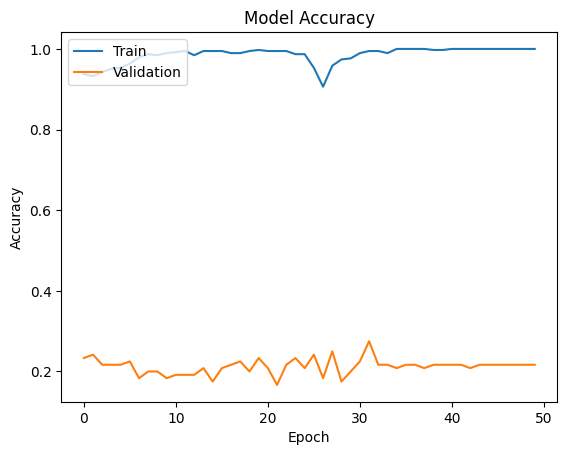

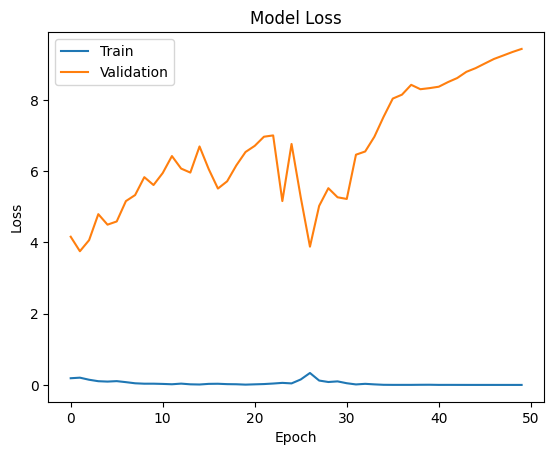

In [ ]:
# 학습 결과 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# 모델 평가
test_loss, test_accuracy = joint_model.evaluate([test_x, test_x], test_y)
print(f"Test accuracy: {test_accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2318 - loss: 8.2697
Test accuracy: 0.2604


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step

c:\Users\jdm03\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_7']. Received: the structure of inputs=('*', '*')
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


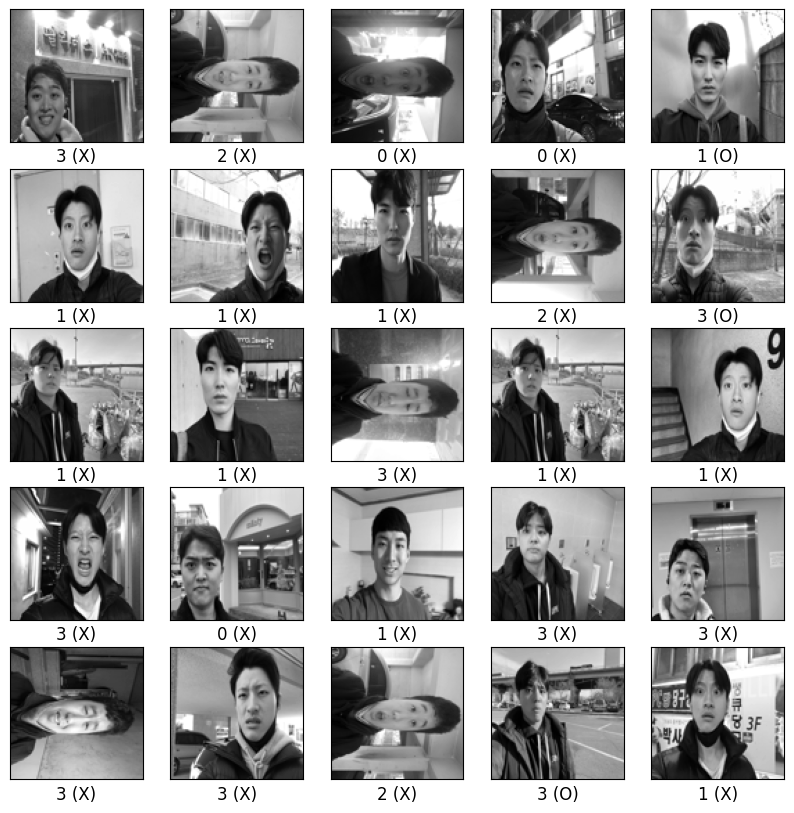

In [ ]:
# 예측 수행 및 샘플 결과 시각화
pred = joint_model.predict([test_x, test_x])

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    is_correct = 'O' if np.argmax(pred[i]) == np.argmax(test_y[i]) else 'X'
    plt.imshow(test_x[i].reshape(96, 96), cmap=plt.cm.gray)
    plt.xlabel(f'{np.argmax(pred[i])} ({is_correct})', fontsize=12)
plt.show()